# Project 2: Predicting-diabetes-outcome-for-women

## YOUR NAME HERE, Mahamadou Ousmane KEITA

# I. Introduction: a description of the dataset and the problem at hand

The project focuses on predicting diabetes outcomes using machine learning models based on the **TAIPEI_diabetes.csv dataset**, which contains data on **15,000 women aged 20–80** who visited Taipei Municipal Medical Center between 2018–2022. The dataset includes **8 features** such as pregnancies, plasma glucose levels, BMI, and family history, with the target variable indicating whether diabetes was diagnosed. 

The objective is to build and deploy a predictive model capable of classifying individuals as diabetic or non-diabetic. The end product will be a **web application** that allows users to input individual health metrics and receive a diabetes prediction in real time, supporting better diagnostic decision-making.

# II. Exploratory Data Analysis and Feature engineering

Let's first have a look at few individuals from the dataset so that, we can have a more detailed inside about the structure of the data.


In [135]:
import pandas as pd

df= pd.read_csv("Data\\TAIPEI_diabetes.csv")

df.head()

PatientID  Pregnancies  PlasmaGlucose  DiastolicBloodPressure  \
0    1354778            0            171                      80   
1    1147438            8             92                      93   
2    1640031            7            115                      47   
3    1883350            9            103                      78   
4    1424119            1             85                      59   

   TricepsThickness  SerumInsulin        BMI  DiabetesPedigree  Age  Diabetic  
0                34            23  43.509726          1.213191   21         0  
1                47            36  21.240576          0.158365   23         0  
2                52            35  41.511523          0.079019   23         0  
3                25           304  29.582192          1.282870   43         1  
4                27            35  42.604536          0.549542   22         0

As we can sse, we have mostly numerical variable which correlate with what we have been told on the project instructions.

We can notice that we have the **Diabetic** variable which is our variable to predict is in fact categorial with **0** meaning that the individual hace no diabetic diagnosed and **1** overwise.

For now, let's focus on the **PatientID** variable which as is name suggest is the ID of our patient.

Let's check if we may have some patient that some extra diagnose on the dataset.

In [138]:
### Check if all values in the column are unique

# Print the result
if df["PatientID"].is_unique:
    print(f"All values in the column PatientID are unique.")
else:
    print(f"The column PatientID contains duplicate values.")

    # Display duplicate values (if any)
    df_duplicated = df[df["PatientID"].duplicated()]
    print("\nWe have",len(df_duplicated),"duplicate values in the column PatientID \n ")
    print("The total number of individuals on the dataset with a duplicated PatientID is:",
    len(df[df["PatientID"].duplicated(keep=False)]["PatientID"]))

The column PatientID contains duplicate values.

We have 105 duplicate values in the column PatientID 
 
The total number of individuals on the dataset with a duplicated PatientID is: 210


Has we can see it, we have 105 Patient that have more than 1 input on the dataset for a total number of 210 duplicated PatientID on the dataset, so we can understand that the same Patient comeback twice to register is information.

So before we decide to either, delete the duplicated values or to keep them, we need to be sure about the value they add to the dataset.

Let's check that with an example here.

In [141]:
#One example
df[ df["PatientID"] == df_duplicated["PatientID"].iloc[0] ]

#Cleaning my workroom
del df_duplicated

I this example, we can see that, for the same PatientID, we can have completely different information except for the predictable variable which is the **Diabetic** colonne.

Which is interesting because if we can have for information about our **Diabetic** variable, no matter the case of diagnosed postive or negative.

Let's just make sure that the duplicated PatientID all brings about new informations.

In [144]:
df.drop_duplicates(subset=None, keep='first', inplace=True)

print("We have in reality",
                            len(df),
        "individual that are not duplicated.")

We have in reality 15000 individual that are not duplicated.


So now, we know that all the informations on the dataset are unique and add value to the dataset (15000 being the total individuals from the complete database). 

We can move on with an other topic.

Let's check if we have missing values on the dataset

<Axes: >

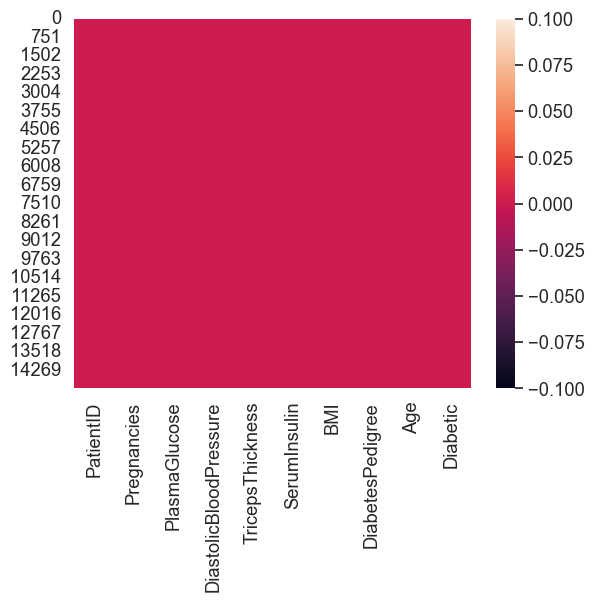

In [147]:
import seaborn as sns

sns.heatmap(df.isna())

No missing values ​​so we can move on.

We will drop the **PatientID** for the rest of the work because, it not useful and take space for nothing.

Now it time to check if we have outliers we need to worry about and inbalances on the **Diabetic** variable we need to consider.

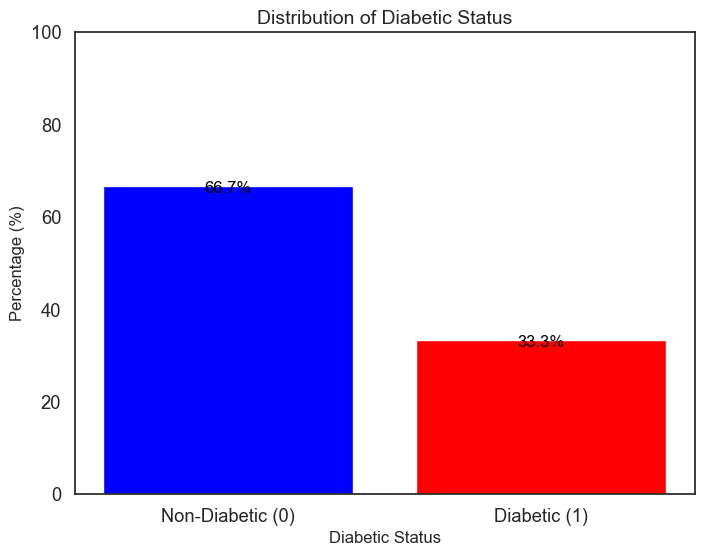

In [150]:
import matplotlib.pyplot as plt

#Let's drop the PatientID columns
df.drop(columns="PatientID", inplace=True)

# Calculate percentages
counts = df['Diabetic'].value_counts(normalize=True) * 100

# Define colors for the binary values
colors = {0: 'blue', 1: 'red'}

# Plot histogram
plt.figure(figsize=(8, 6))
bars = plt.bar(counts.index, counts, color=[colors[val] for val in counts.index])

# Add percentage text on top of bars
for bar, percentage in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 2,
             f'{percentage:.1f}%', ha='center', va='bottom', fontsize=12, color='black')

# Customize the plot
plt.xticks([0, 1], ['Non-Diabetic (0)', 'Diabetic (1)'])
plt.xlabel("Diabetic Status", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
plt.title("Distribution of Diabetic Status", fontsize=14)
plt.ylim(0, 100)  # Ensure the y-axis goes up to 100%

plt.show()

We have inbalance in the variable to predict which is the variable **Diabetic**, so we need to take that in cosideration when dealing with outliers.

C:\Users\aroum\AppData\Local\Temp\ipykernel_46900\2264133608.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


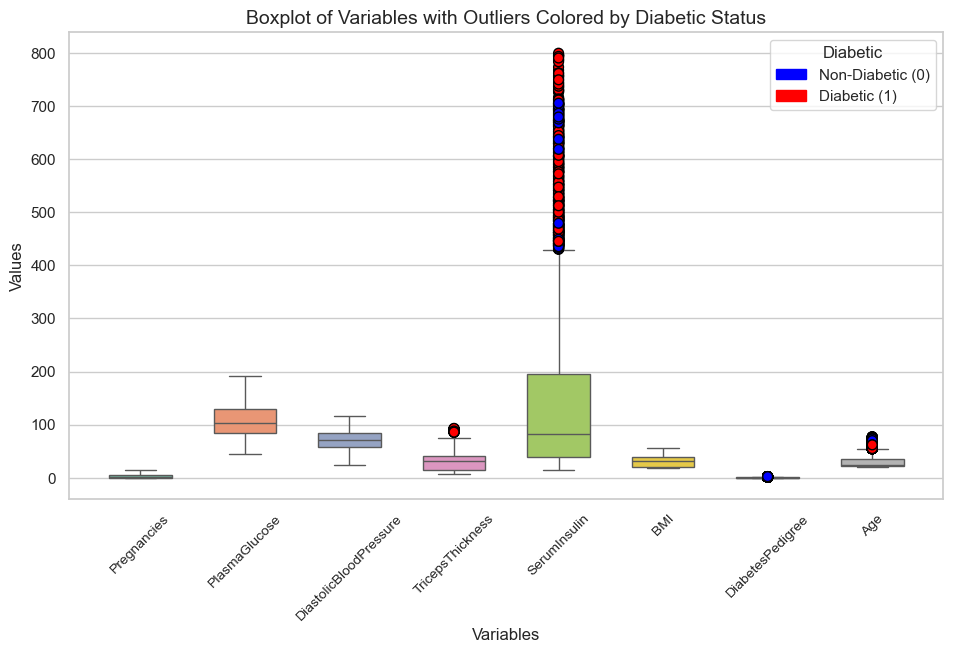

In [153]:
import seaborn as sns
import numpy as np


# Melt the DataFrame to long-form for easier plotting
df_melted = df.melt(id_vars='Diabetic', var_name='Variable', value_name='Value')

# Initialize the plot
plt.figure(figsize=(10, 7))
sns.set(style="whitegrid")

# Generate a boxplot without the outliers
sns.boxplot(
    x='Variable',
    y='Value',
    data=df_melted,
    width=0.6,
    palette='Set2',  # Unique colors per variable
    showfliers=False  # Hide default outliers
)

# Overlay individual points and color outliers based on Diabetic status
for i, variable in enumerate(df_melted['Variable'].unique()):
    subset = df_melted[df_melted['Variable'] == variable]
    
    # Calculate whisker limits for outliers
    Q1 = np.percentile(subset['Value'], 25)
    Q3 = np.percentile(subset['Value'], 75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = subset[(subset['Value'] < lower_limit) | (subset['Value'] > upper_limit)]
    
    # Plot outliers as scatter points with colors based on 'Diabetic'
    plt.scatter(
        [i] * len(outliers),  # X-coordinates (aligned with boxplot position)
        outliers['Value'],  # Y-coordinates
        c=outliers['Diabetic'].apply(lambda x: 'blue' if x == 0 else 'red'),
        edgecolor='black',
        s=50,  # Marker size
        zorder=5,  # Ensure points are on top
        label='_nolegend_'
    )

# Add legend for color meaning
from matplotlib.patches import Patch
legend_handles = [
    Patch(color='blue', label='Non-Diabetic (0)'),
    Patch(color='red', label='Diabetic (1)')
]
plt.legend(handles=legend_handles, loc='upper right', title='Diabetic')

# Rotate x-axis labels
plt.xticks(rotation=45, fontsize=10)

# Customize the plot
plt.title("Boxplot of Variables with Outliers Colored by Diabetic Status", fontsize=14)
plt.xlabel("Variables", fontsize=12)
plt.ylabel("Values", fontsize=12)

# Adjust layout for clarity
plt.tight_layout(pad=2)

# Show the plot
plt.show()

##Cleaning my environnement
del df_melted

In terms of outliers, we have 4 variables to worry about, the **Serum Insulin** seem to be the most challenging case to study, we can also add that our outliers are concerned by higher values not lower values (to confirm with the variable DiabetesPedigree).

Let's have a deeper look at those 4 variables.

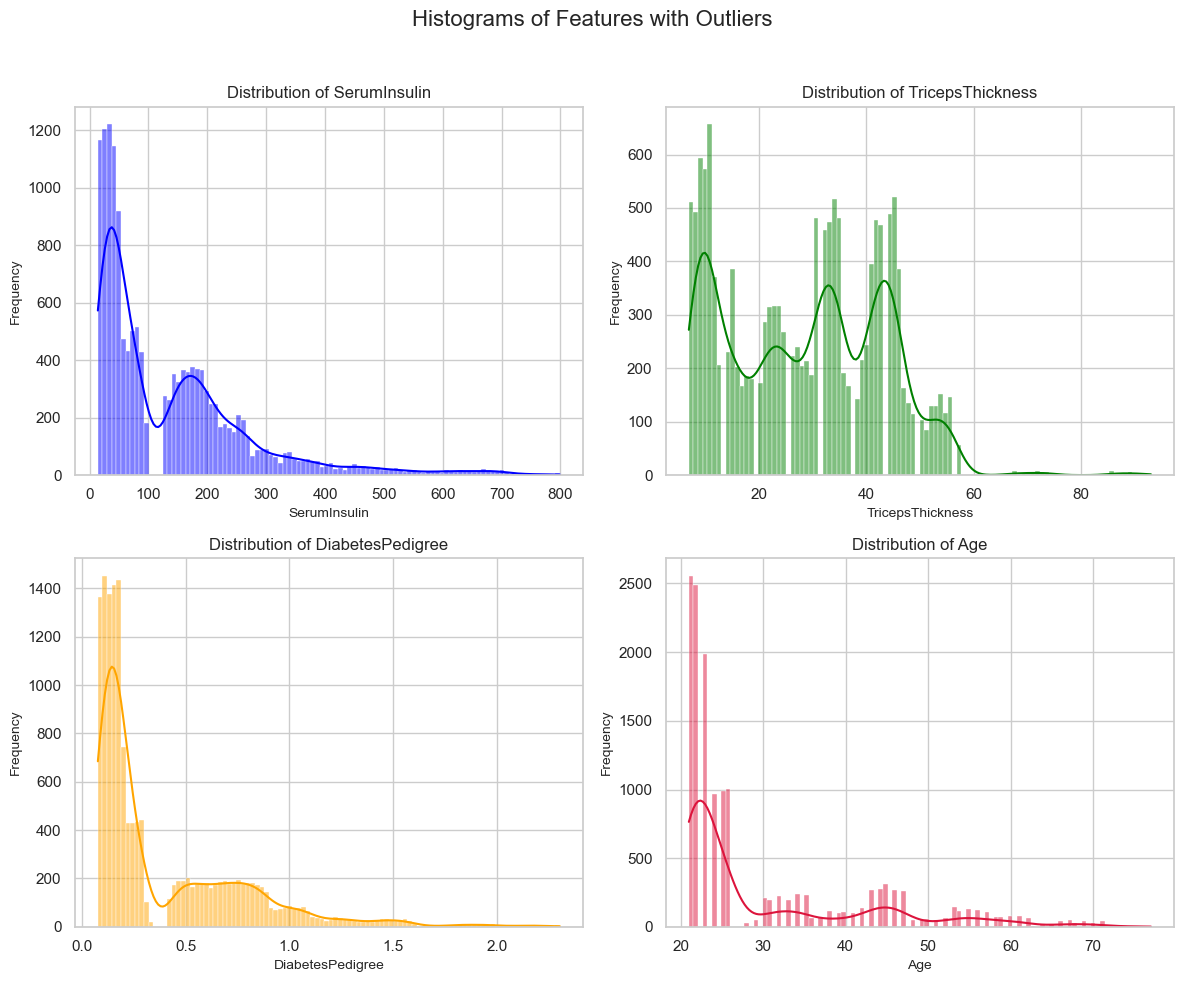

In [156]:


# Set Seaborn style for nice visuals
sns.set(style="whitegrid", palette="muted", color_codes=True)

# Define the 4 features to plot
outliers_features = ['SerumInsulin', 'TricepsThickness', 'DiabetesPedigree', 'Age']

# Define a list of colors for each feature
colors = ['blue', 'green', 'orange', 'crimson']

# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Adjust the figure size as needed
fig.suptitle("Histograms of Features with Outliers", fontsize=16)

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot histograms for each feature with unique colors
for i, (feature, color) in enumerate(zip(outliers_features, colors)):
    sns.histplot(df[feature], bins=100, kde=True, ax=axes[i], color=color)
    axes[i].set_title(f"Distribution of {feature}", fontsize=12)
    axes[i].set_xlabel(feature, fontsize=10)
    axes[i].set_ylabel("Frequency", fontsize=10)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ensure the main title does not overlap
plt.show()


When we focus on the type of distribution of the variables with outliers, we can see that, most of them have a skewed looking shape more or less.

Based on that, we may be tempted to keep the outliers and to just add a $\log$ transformation to reduce theirs impacts.

But before going any further, let's check the impacts it may have on the balance of the currents classes.

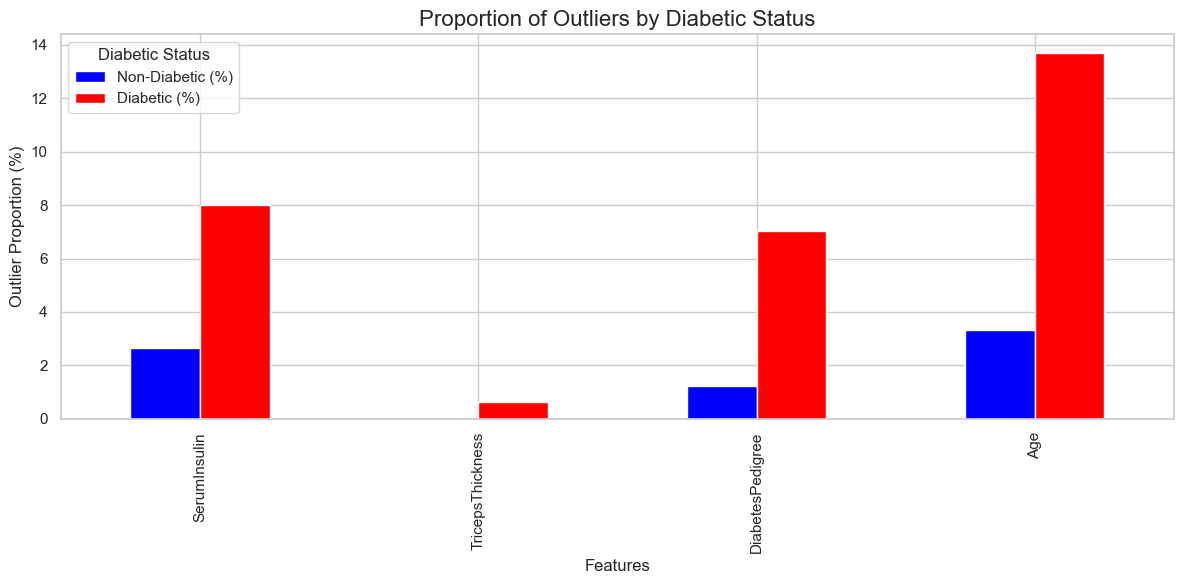

In [159]:

# Set Seaborn style for nice visuals
sns.set(style="whitegrid", palette="muted", color_codes=True)

# Define a function to detect outliers using IQR method
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data < lower_bound) | (data > upper_bound)

# Create a DataFrame to store outlier-related data
df_outliers = pd.DataFrame(index=df.index)

#Always check the work
df_outliers.head()

# Proportion of Outliers per Category (Diabetic=0 and Diabetic=1)
outlier_proportions = []

# Detect and save outliers in df_outliers
for feature in outliers_features:
    # Detect outliers for the current feature
    is_outlier = detect_outliers_iqr(df[feature])
    
    
    
    # Add the actual outlier values to df_outliers
    outlier_column_name = f"{feature}_outliers"
    df_outliers[outlier_column_name] = is_outlier.astype(int)    # Add binary indicator to df_outliers (1 = outlier, 0 = non-outlier)

    df_outliers[outlier_column_name] = df[feature].where(is_outlier, other=0)
    
    # Calculate proportion of outliers for each group
    proportions = df.groupby("Diabetic")[feature].apply(
        lambda x: is_outlier.loc[x.index].mean() * 100
    )
    outlier_proportions.append(proportions)

# Combine results into a DataFrame for easier plotting
outlier_summary = pd.DataFrame(outlier_proportions, index=outliers_features)
outlier_summary.columns = ['Non-Diabetic (%)', 'Diabetic (%)']

# Plot the proportions as a grouped barplot
outlier_summary.plot(kind='bar', figsize=(12, 6), color=['blue', 'red'])
plt.title("Proportion of Outliers by Diabetic Status", fontsize=16)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Outlier Proportion (%)", fontsize=12)
plt.legend(title="Diabetic Status")
plt.tight_layout()
plt.show()



We can clearly see that most of time, the outliers are from the class of those with diabetise which is the class **1**.

And remember that this the class that is under represent on the dataset, so by removing or reduce the impacts of the outliers, we may lose a lot of valuable and specialy "rare" information on our unbalance variable to predict.

So we may just keep them and later on may be check if our models are doing better without them.

Now let's see if it will be interesting to add some functionnal changes to some variable or to remove them from the database

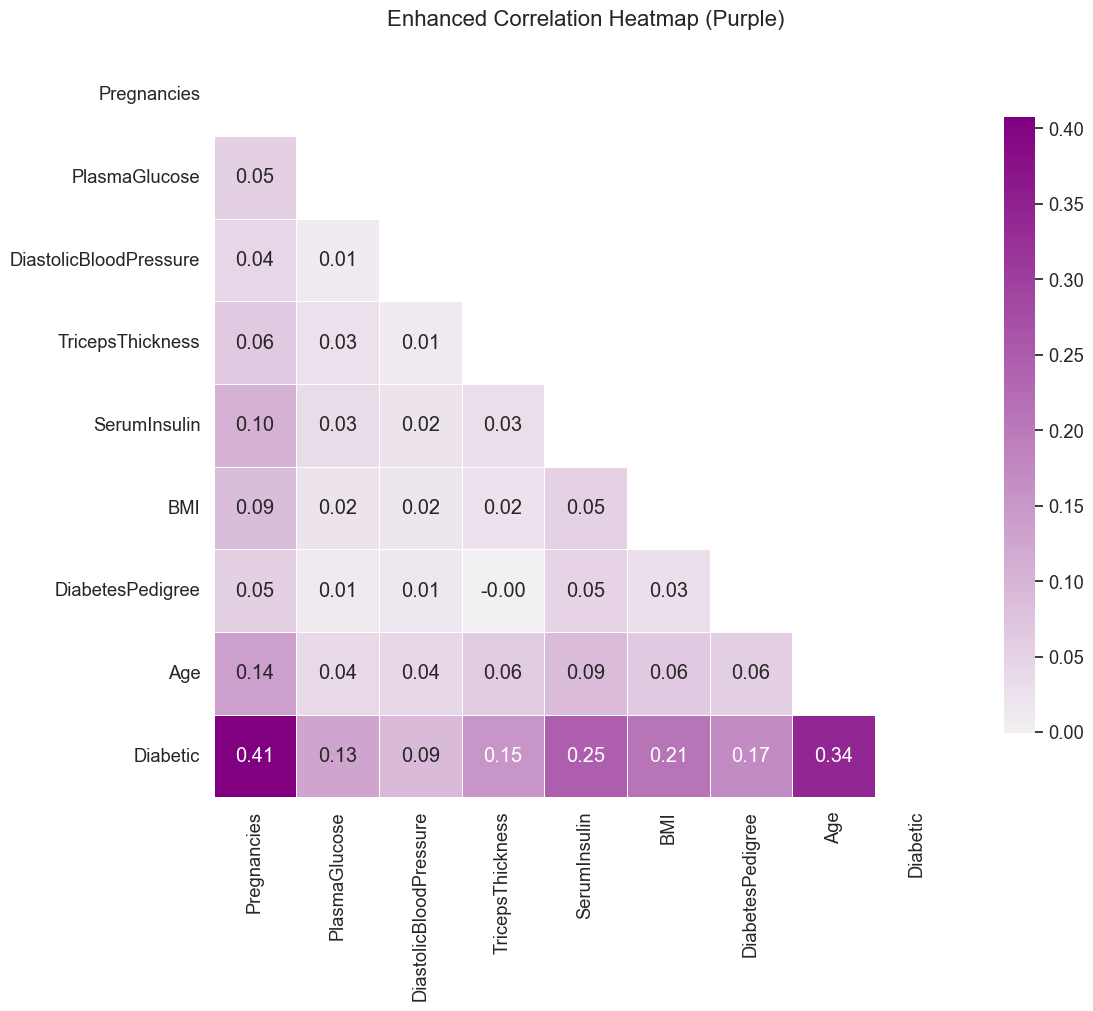

In [162]:
# Set a larger figure size and clean style for readability
plt.figure(figsize=(12, 10))
sns.set(style="white", font_scale=1.2)

# Compute the correlation matrix
correlation_matrix = df.corr()

# Create a mask to hide the upper triangle (for a clean look)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Define a purple colormap
cmap = sns.light_palette("purple", as_cmap=True)  # Light purple gradient colormap

# Create the heatmap
sns.heatmap(
    correlation_matrix, 
    mask=mask,  # Apply the mask
    cmap=cmap,  # Use the purple colormap
    annot=True,  # Show correlation coefficients
    fmt=".2f",   # Format numbers to 2 decimal places
    linewidths=0.5,  # Add lines between cells for better readability
    cbar_kws={"shrink": 0.8},  # Adjust color bar size
    square=True  # Keep cells square-shaped
)

# Add a title
plt.title("Enhanced Correlation Heatmap (Purple)", fontsize=16, pad=20)

# Display the plot
plt.show()


Base on the corrplot, all our variables have a correlation below 0.5 which means that we can keep all the variables on our data base due to none correlation between each overs.


Now let's check if pairs of variable can clearly define clusters of people with diabetise or not.

Let's check that with a pairplot.

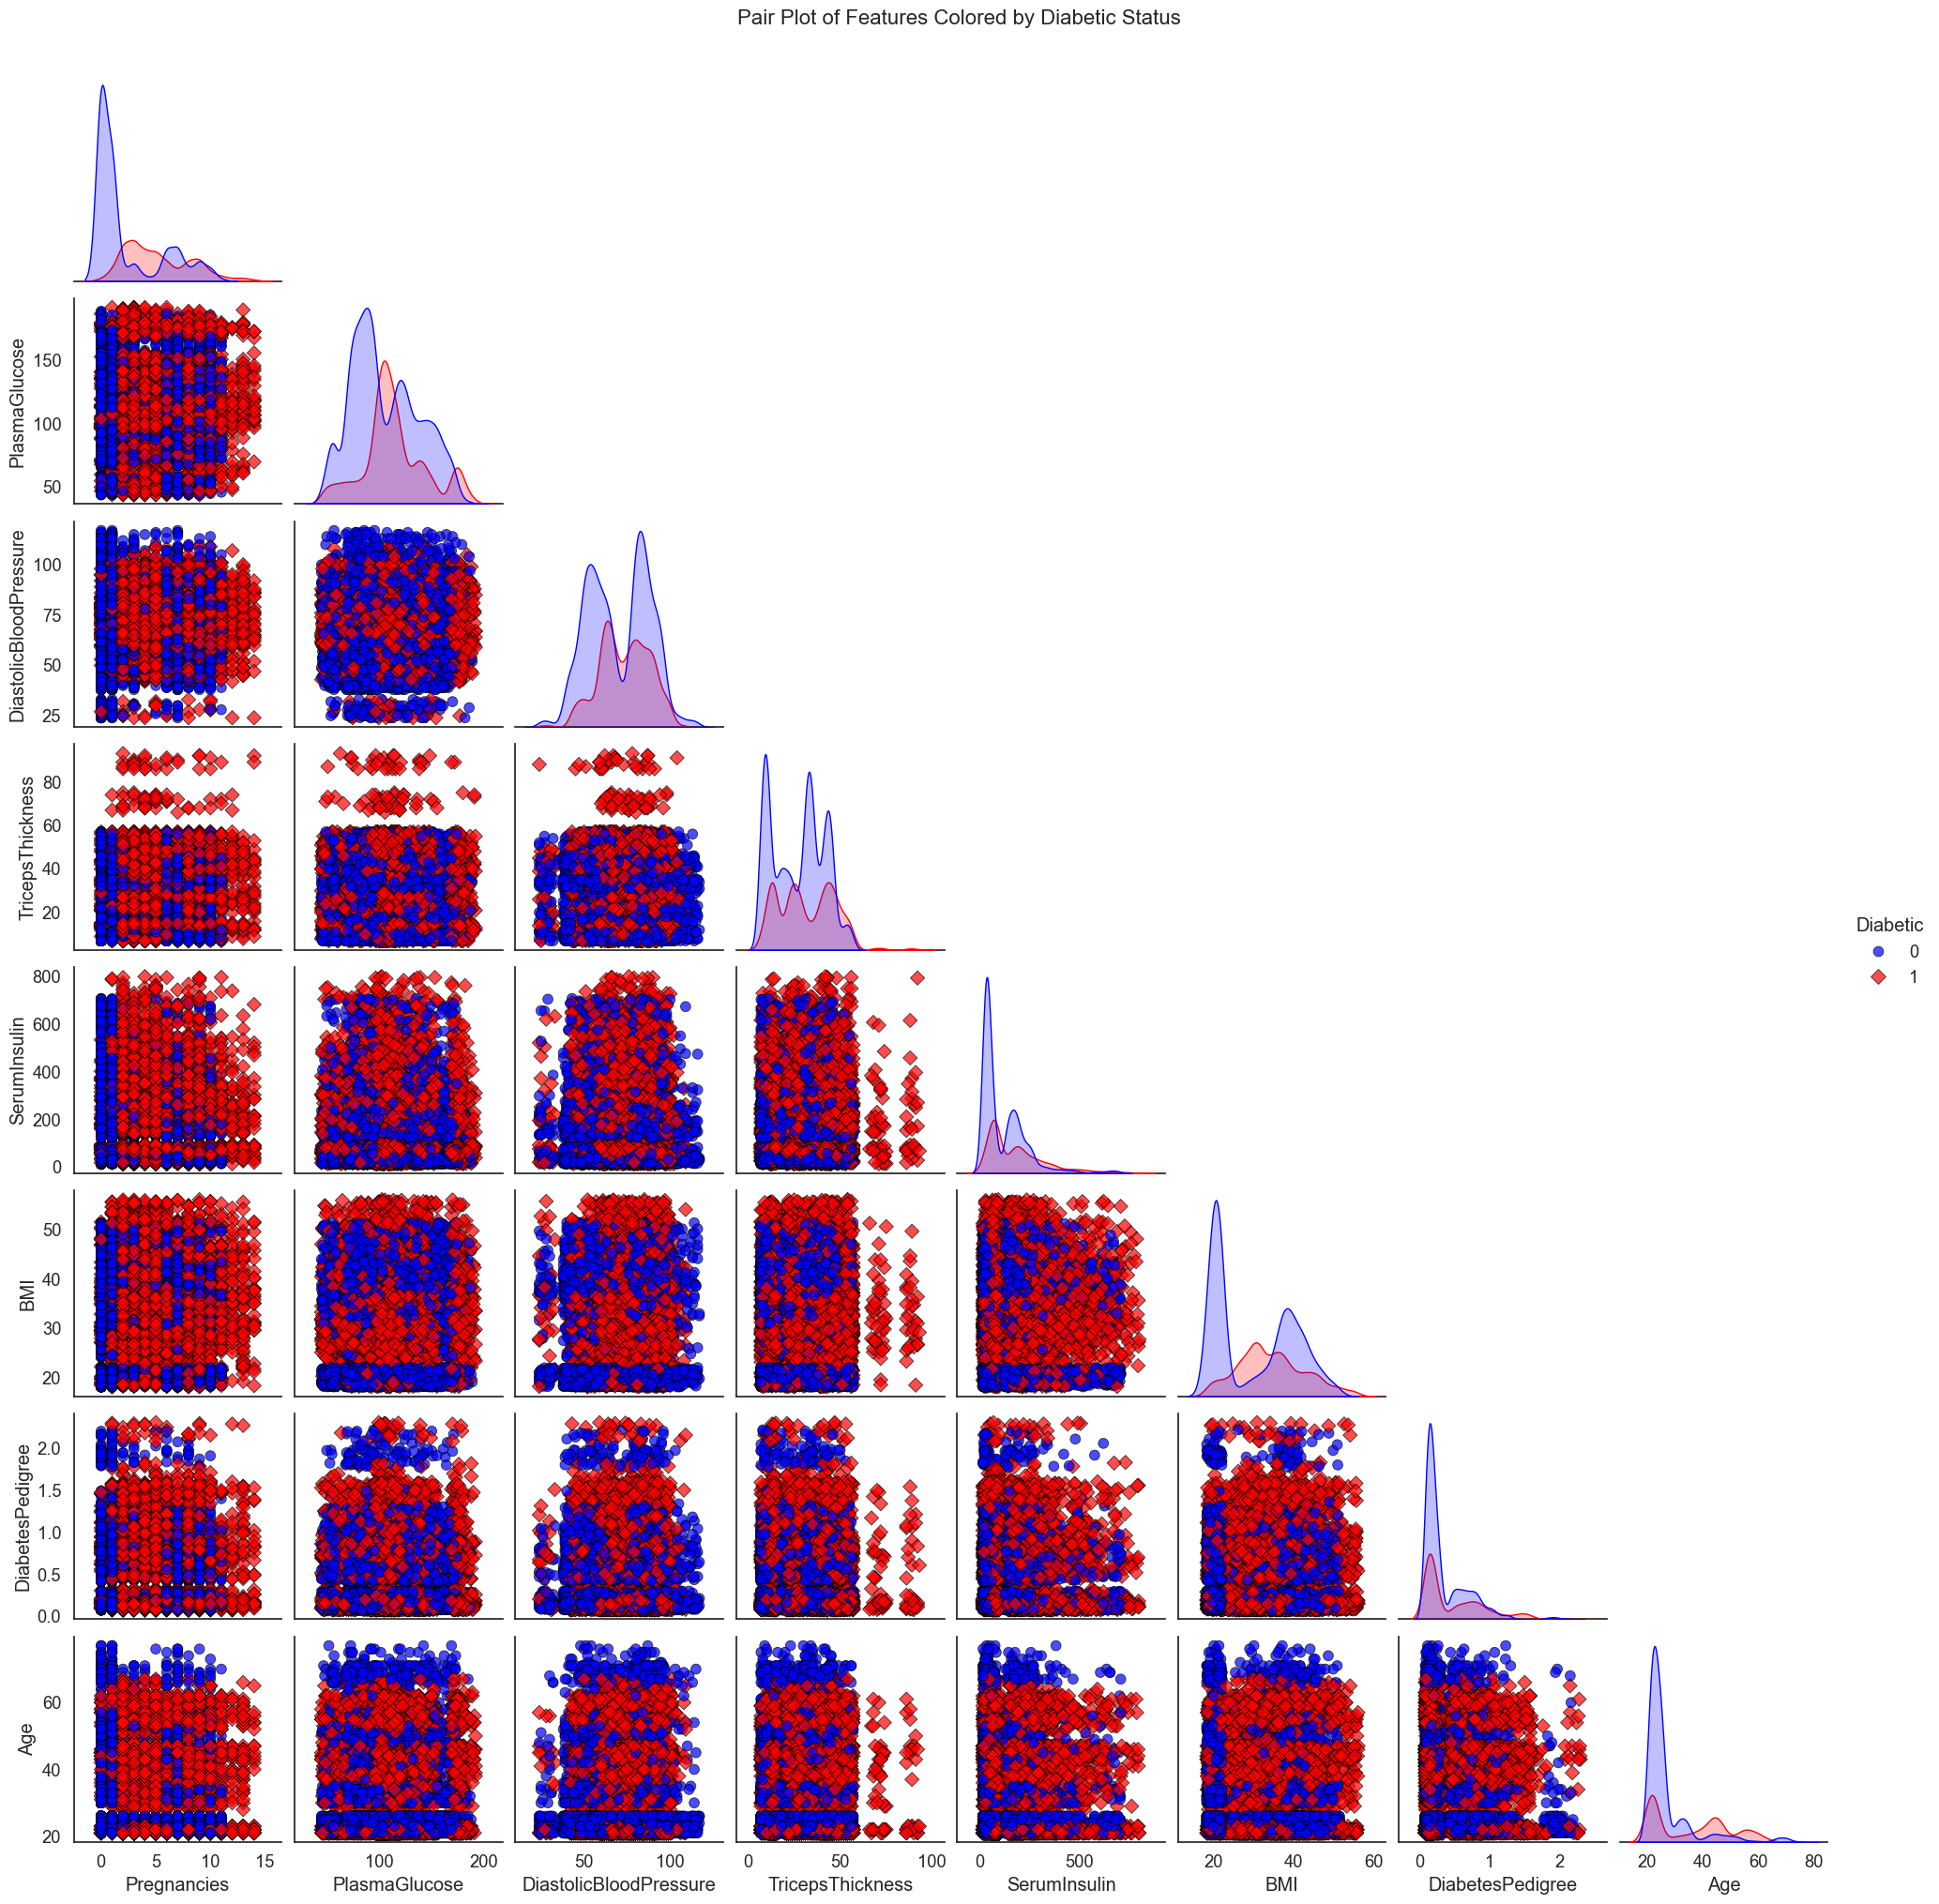

In [165]:
# Custom color palette for the binary class: 0 -> Blue, 1 -> Red
palette = {0: "blue", 1: "red"}

# Create the pair plot
g = sns.pairplot(
    df, 
    hue="Diabetic", 
    palette=palette,
    diag_kind="kde",  # KDE plots on the diagonal
    markers=["o", "D"],  # Use distinct markers for each class
    corner=True,
    plot_kws={'alpha': 0.7, 's': 60, 'edgecolor': 'black'}  # Adjust marker size, transparency, and edges
)

# Add a main title
g.fig.suptitle("Pair Plot of Features Colored by Diabetic Status", y=1.02, fontsize=16)

# Display the plot
plt.show()

As we can see on the graph, the answer is no.

Let's check if individualy, some variable are irrelevant in order to predictic if yes or not a person have **Diabetise**

C:\Users\aroum\AppData\Local\Temp\ipykernel_46900\1417585630.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\aroum\AppData\Local\Temp\ipykernel_46900\1417585630.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\aroum\AppData\Local\Temp\ipykernel_46900\1417585630.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\aroum\AppData\Local\Temp\ipykernel_46900\1417585630.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `h

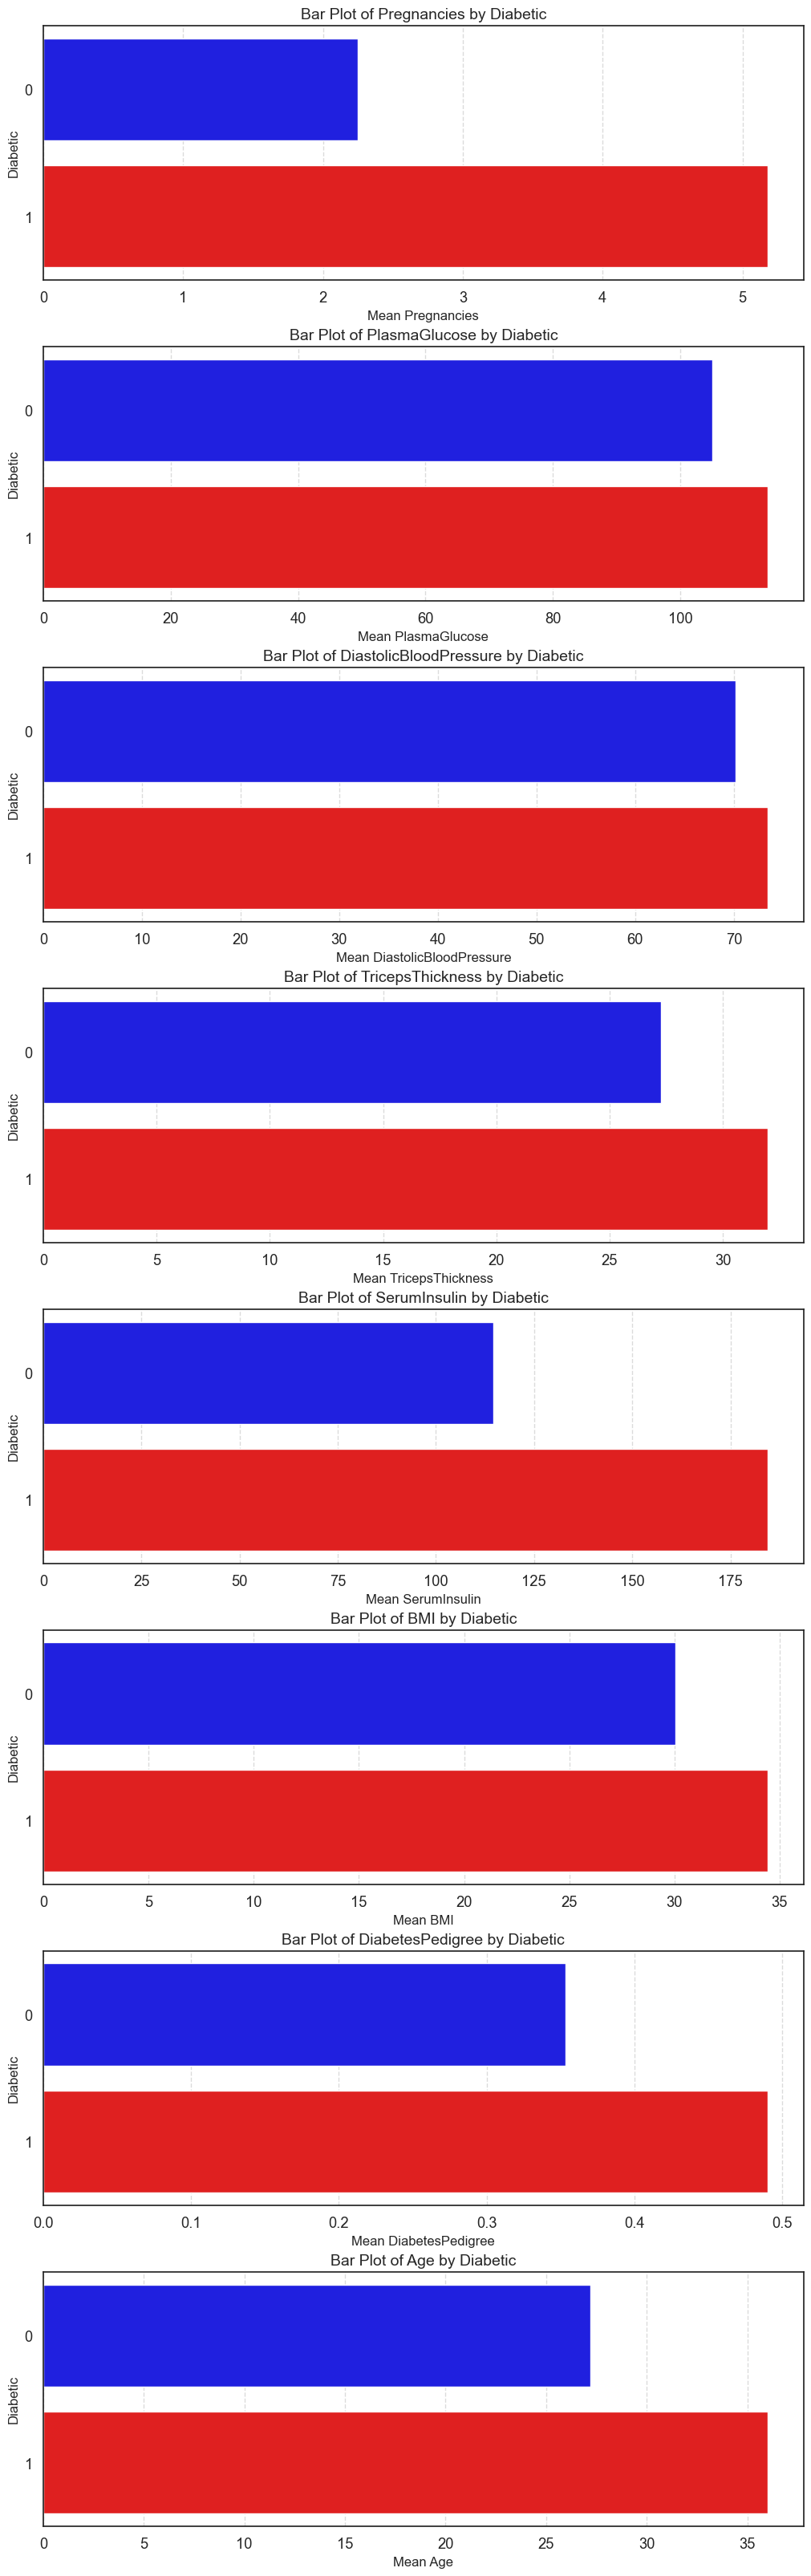

In [167]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_horizontal_bar_in_rows(df, binary_column):
    """
    Creates a row of horizontal bar plots for each numeric column in the DataFrame with a specified binary column as X.

    Args:
    df (pd.DataFrame): Input DataFrame.
    binary_column (str): The binary column to use as the grouping variable.
    """
    # Ensure the binary column is present
    if binary_column not in df.columns:
        raise ValueError(f"The specified column '{binary_column}' is not in the DataFrame.")
    
    # Convert the binary column to a string if needed
    df[binary_column] = df[binary_column].astype(str)

    # Filter numeric columns excluding the binary column
    numeric_columns = [col for col in df.select_dtypes(include='number').columns if col != binary_column]
    
    # Set up the plot grid
    num_vars = len(numeric_columns)
    fig, axes = plt.subplots(num_vars, 1, figsize=(10, 4 * num_vars), constrained_layout=True)
    
    # If there's only one numeric column, axes might not be iterable
    if num_vars == 1:
        axes = [axes]

    for ax, col in zip(axes, numeric_columns):
        # Prepare data for plotting
        grouped_data = df.groupby(binary_column)[col].mean().reset_index()
        
        # Plot the data horizontally
        sns.barplot(
            y=binary_column, 
            x=col, 
            data=grouped_data, 
            ax=ax, 
            palette={"0": "blue", "1": "red"},
            orient="h"  # Horizontal orientation
        )
        
        # Customize the subplot
        ax.set_title(f"Bar Plot of {col} by {binary_column}", fontsize=14)
        ax.set_xlabel(f"Mean {col}", fontsize=12)
        ax.set_ylabel(binary_column, fontsize=12)
        ax.grid(axis="x", linestyle="--", alpha=0.7)

    plt.show()



# Example usage
# df = pd.read_csv("your_dataset.csv")
plot_horizontal_bar_in_rows(df, binary_column="Diabetic")


Based on the graphics, the only variable that have high relevancy are, **Pregnacie** and **is_outlier** the others have i like to say medium to low values.

Let's do some statistical tests to check if we have significants differences between groups even if it is low differences, in our case, we are working with not so much data, so we can give our self to have the freedom to keep as much variable as possible even if the impacts are low, statistical significancy may be enough.

We will use the **Mann Whitney test** due to the fa ct thtat is condition are just really easy to fulfill and by default we fulfill them so it is just an plug and play (not like the t test).

In [171]:
from scipy.stats import mannwhitneyu

def mann_whitney_test(df, binary_var, alpha=0.05):
    """
    Separates a DataFrame into two groups based on a binary variable and applies 
    the Mann-Whitney U test to all numeric variables. Includes a significance column.
    
    Parameters:
    - df: pd.DataFrame
        The DataFrame containing the data.
    - binary_var: str
        The name of the binary variable (column) used for grouping.
    - alpha: float, optional (default=0.05)
        The significance level for determining if a result is statistically significant.
        
    Returns:
    - results: pd.DataFrame
        A DataFrame containing the U statistic, p-value, and significance for each numeric variable.
    """
    # Validate input
    if binary_var not in df.columns:
        raise ValueError(f"The binary variable '{binary_var}' is not in the DataFrame.")
    
    # Identify numeric columns
    numeric_vars = df.columns.drop(binary_var)
    if numeric_vars.empty:
        raise ValueError("No numeric variables found in the DataFrame.")

    # Prepare results
    results = []

    # Separate the groups based on the binary variable
    group_0 = df[df[binary_var] == "0"]
    group_1 = df[df[binary_var] == "1"]

    # Ensure both groups have data
    if group_0.empty or group_1.empty:
        raise ValueError("One of the groups is empty. Check the binary variable values.")

    # Apply the Mann-Whitney U test for each numeric variable
    for var in numeric_vars:
        u_stat, p_value = mannwhitneyu(group_0[var], group_1[var], alternative='two-sided')
        is_significant = p_value < alpha
        results.append({
            "Variable": var, 
            "U statistic": u_stat, 
            "p-value": p_value, 
            "is_significant": is_significant
        })

    # Convert results to a DataFrame
    return pd.DataFrame(results)



# Example usage:
test_results = mann_whitney_test(df, binary_var="Diabetic")
print(test_results)


                 Variable  U statistic        p-value  is_significant
0             Pregnancies   10473690.0   0.000000e+00            True
1           PlasmaGlucose   20570666.5   3.066940e-70            True
2  DiastolicBloodPressure   22193930.0   3.035833e-29            True
3        TricepsThickness   20390006.5   5.597841e-76            True
4            SerumInsulin   15619295.0  3.980423e-308            True
5                     BMI   18808251.0  2.076209e-135            True
6        DiabetesPedigree   21615572.0   9.424051e-42            True
7                     Age   18747808.0  8.794664e-140            True


Based on the test results, we will keep every features from our database.

Now let's do some machine learning.

# III. Machine Learning : Model Selection, Comparison and Evaluation

# III.1 Model Selection

Here, we are dealing this a classification case and we do not have a hugh amout of data to process, nor we want to understand the variables that causes Diabetise, we just want to have the best prediction model possible so we have the freedom to test every model we want.

That being said, in our EDA step, we have gathered some knowledge that are usefull to takes in account.

First, we do not have a clear separation that can drowen from each couple of variable (pairplot) and we have a highly significant distinction for each variables laws depending on the groups the values belong.

So a lot of classification models can fit our needs.

Let's try those :

* **GLM**
* **Decisition Tree**
* **Random Forest**
* **XGBoost**

The goal here is to test methods that don't cost a lot in term of building process and computation in the first place (unlike neuronal networks) and see what we can except from those models first.

We are using the basic models such as GLM and Decision Tree and progress with more effective models like random forest and XGBoost. The goal here is to see if small models are enough, or is the need to directly dive into for competive models like the **XGBoost**.

Our **Baseline** will be the naive prediction which is basically predicting the most domination class and each try and in our EDA, we have seen that we will get an error of **33,33%** because the dominant class (class 0) represent **66,7%** percent of the dataset.

To compare the results, we will use the **k-fold** method in order for us to have an idea of the mean accuracy of the model and also the variance of the prediction quality. The k-fold method will also insure us with a lot of score to compare so we can have a really robust expectation of the quality of our models.

We will also use the **stratification** method which consist of keep the same proportion of the initial classes in the variable to predict when splitting the data in train and test datasets.

In [174]:
!pip install xgboost

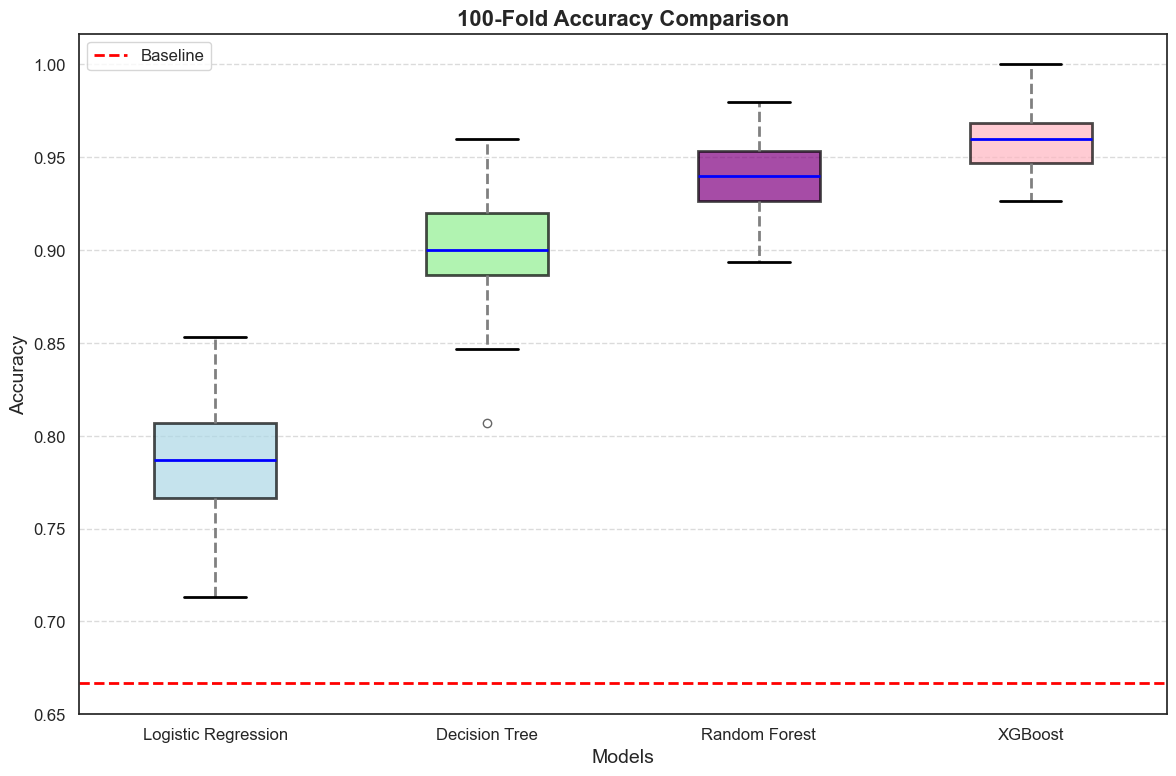

In [175]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

def kfold_evaluation(models, X, y, n_splits=5, random_state=42):
    """
    Evaluate models using Stratified K-Fold cross-validation.
    
    Parameters:
    - models: dict
        Dictionary of models with their names as keys.
    - X: pd.DataFrame
        Feature matrix.
    - y: pd.Series or np.array
        Target variable.
    - n_splits: int, optional (default=5)
        Number of folds in Stratified K-Fold.
    - random_state: int, optional (default=42)
        Random state for reproducibility.
        
    Returns:
    - results: dict
        Dictionary containing accuracy results for each model.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    results = {name: [] for name in models.keys()}
    
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        for name, model in models.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            results[name].append(accuracy)
    
    return results

# Setup the variables
y = "Diabetic"
X = df.columns.drop(y)

df[y] = df[y].astype(int) #let's correct the type of the Diabetic variable

X = df[X]
y = df[y]

# Baseline model (proportion of the dominant class)
dominant_class_proportion = y.value_counts(normalize=True).max()

# Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=10000, random_state=42),
    "Decision Tree" : DecisionTreeClassifier(random_state=100),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42),
    
}

# Perform K-Fold evaluation
results = kfold_evaluation(models, X, y, n_splits=100)

# Improved Boxplot Visualization with Unique Colors
def plot_kfold_results(results, baseline, title="K-Fold Accuracy Comparison"):
    """
    Plot the results of K-Fold evaluation as enhanced boxplots.

    Parameters:
    - results: dict
        Dictionary containing accuracy results for each model.
    - baseline: float
        Baseline accuracy value to plot as a horizontal line.
    - title: str, optional
        Title of the plot.
    """
    plt.figure(figsize=(12, 8))
    
    # Generate unique colors for each model
    colors = ['lightblue', 'lightgreen', 'purple', 'lightpink', 'lightyellow']
    
    # Boxplot settings
    boxprops = dict(linewidth=2, color="black")
    whiskerprops = dict(linewidth=2, linestyle="--", color="gray")
    capprops = dict(linewidth=2, color="black")
    medianprops = dict(linewidth=2, color="blue")
    flierprops = dict(marker='o', color='red', alpha=0.6)
    
    # Create the boxplot
    box = plt.boxplot(
        results.values(),
        labels=results.keys(),
        boxprops=boxprops,
        whiskerprops=whiskerprops,
        capprops=capprops,
        medianprops=medianprops,
        flierprops=flierprops,
        patch_artist=True
    )
    
    # Assign unique colors to each box
    for patch, color in zip(box['boxes'], colors[:len(results)]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Plot the baseline
    plt.axhline(y=baseline, color="red", linestyle="--", linewidth=2, label="Baseline")
    
    # Add titles and labels
    plt.title(title, fontsize=16, fontweight="bold")
    plt.ylabel("Accuracy", fontsize=14)
    plt.xlabel("Models", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Call the improved plot function
plot_kfold_results(results, dominant_class_proportion, title="100-Fold Accuracy Comparison")




Let's check the importance of the feature on the algorithm performances.

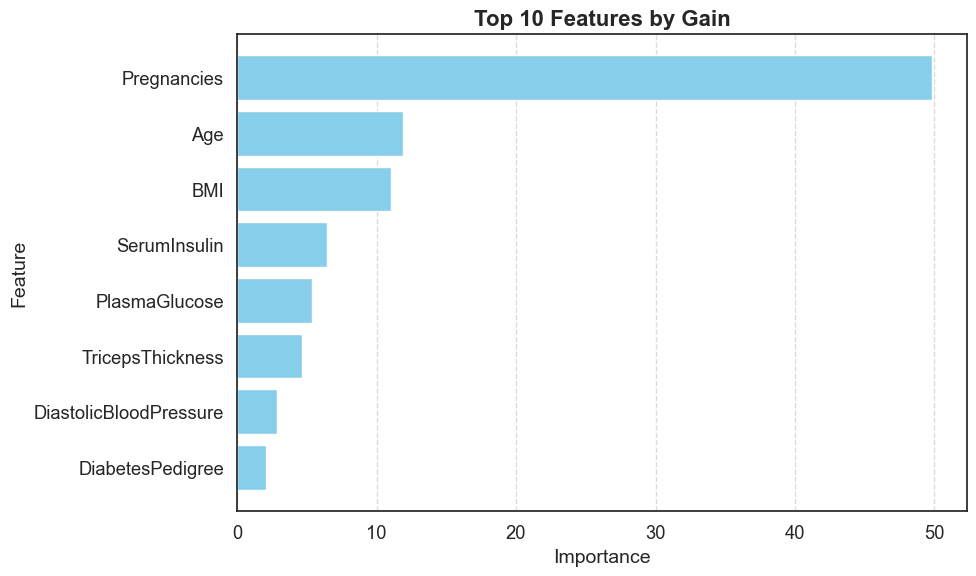

In [177]:

def plot_feature_importance(model, importance_type='gain', max_features=10):
    """
    Plot the feature importance for an XGBoost model.

    Parameters:
    - model: XGBClassifier
        The trained XGBoost model.
    - importance_type: str, optional (default='gain')
        Type of importance ('weight', 'gain', 'cover', 'total_gain', 'total_cover').
    - max_features: int, optional (default=10)
        Maximum number of features to display.

    Returns:
    - None
    """
    # Get feature importance scores
    importance = model.get_booster().get_score(importance_type=importance_type)
    
    # Convert to a DataFrame
    importance_df = pd.DataFrame(
        {'Feature': list(importance.keys()), 'Importance': list(importance.values())}
    ).sort_values(by="Importance", ascending=False)
    
    # Select the top features
    top_features = importance_df.head(max_features)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
    plt.xlabel("Importance", fontsize=14)
    plt.ylabel("Feature", fontsize=14)
    plt.title(f"Top {max_features} Features by {importance_type.capitalize()}", fontsize=16, fontweight="bold")
    plt.gca().invert_yaxis()  # Reverse order for better visualization
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Train the XGBoost model on the worst-performing fold's training data
xgboost = XGBClassifier(eval_metric="logloss", random_state=42).fit(X,y)
plot_feature_importance(xgboost, importance_type='gain', max_features=10)

Base on this graphic, some feature looks pretty irrelevant, but note that we are working with the **XGBoost** algorithm.

We can notice that some of our variables with outliers are on the top 5 of the most important variable (**Age** and **SerumInsulin**).

We have decided to keep a dataframe with the informations reliated to the outliers, so we can add them to the model and keep if they bring about some value.

In [180]:
# Ensure proper alignment of indices between df and df_outliers
df_outliers = df_outliers.reindex(df.index)

# Iterate through columns in df_outliers
for col in df_outliers.columns:
    if col.endswith('_outliers'):  # Check if the column name ends with '_outliers'
        # Extract the corresponding base column name
        base_col = col.replace('_outliers', '')
        
        # Check if the base column exists in df
        if base_col in df.columns:
            # Handle NaN values by filling them with 0 or other strategies
            df_outliers[col] = df_outliers[col].fillna(0)  # Replace NaN with 0 in df_outliers
            df[base_col] = df[base_col].fillna(0)          # Replace NaN with 0 in df
            
            # Create a new column in df by multiplying
            df[f"{col}"] = df[base_col] * df_outliers[col]

# Display the updated DataFrame
df.head()

Pregnancies  PlasmaGlucose  DiastolicBloodPressure  TricepsThickness  \
0            0            171                      80                34   
1            8             92                      93                47   
2            7            115                      47                52   
3            9            103                      78                25   
4            1             85                      59                27   

   SerumInsulin        BMI  DiabetesPedigree  Age  Diabetic  \
0            23  43.509726          1.213191   21         0   
1            36  21.240576          0.158365   23         0   
2            35  41.511523          0.079019   23         0   
3           304  29.582192          1.282870   43         1   
4            35  42.604536          0.549542   22         0   

   SerumInsulin_outliers  TricepsThickness_outliers  \
0                      0                          0   
1                      0                          0   
2                      0                          0   
3                      0                          0   
4                      0                          0   

   DiabetesPedigree_outliers  Age_outliers  
0                        0.0             0  
1                        0.0             0  
2                        0.0             0  
3                        0.0             0  
4                        0.0             0

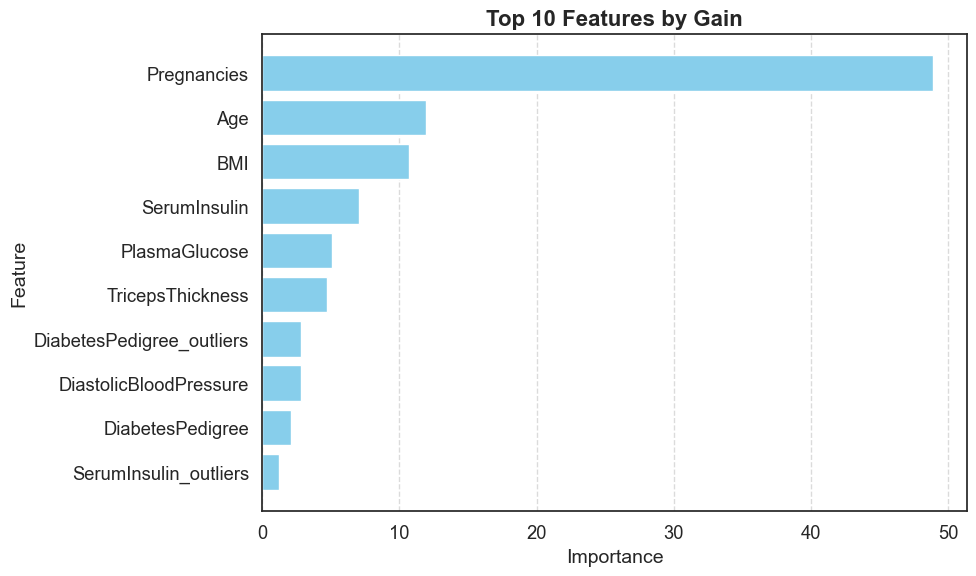

In [184]:
X = df[df.columns.drop("Diabetic")]
y = df["Diabetic"]

# Train the XGBoost model on the worst-performing fold's training data
xgboost = XGBClassifier(eval_metric="logloss", random_state=42).fit(X,y)
plot_feature_importance(xgboost, importance_type='gain', max_features=10)

We can see that adding them to the model, to not seem to add a lot of value in the predictions.

But we are not done yet with the feature engineering part, indeed, one pratice we have not tried yet is to add functionnals modifications of our variables to the set of features.

In fact, we seen for example that for our current, variables, we have a significant distinction between the distribution of the two group of diabet cases (with the mann whitney test).

So, we can expect that adding functionnal changes to the variables can change the scope of the impact so much so that some variable with low impacts can be at the top interm of impact.

Let's start with some polynomial changes, by doing so we will also add the interaction term between variables which is a commonly use method in BioStatistic when we want to improve the predictions quality.

In [187]:

import pandas as pd
from itertools import combinations_with_replacement

def polynomial_expansion(df, columns, degree):
    """
    Generate polynomial features including powers and interaction terms
    (e.g., X**2, X*Y, Y**2) for the specified columns up to a given degree.

    Args:
        df (pd.DataFrame): Input DataFrame.
        columns (list): List of column names to include in the polynomial expansion.
        degree (int): The maximum degree for the polynomial expansion.

    Returns:
        pd.DataFrame: DataFrame with polynomial features added.
    """
    for d in range(1, degree + 1):  # Iterate over degrees
        # Generate combinations with replacement to include interaction terms and powers
        for combo in combinations_with_replacement(columns, d):
            if len(combo) == 1:
                # Single feature to the power of d (e.g., X**2)
                col_name = f"{combo[0]}**{d}"
                df[col_name] = df[combo[0]] ** d
            else:
                # Interaction term (e.g., X*Y)
                col_name = "*".join(combo)
                df[col_name] = df[list(combo)].prod(axis=1)
    return df


degree = 2  # Up to second degree

df = polynomial_expansion(df, df.columns.drop("Diabetic"), degree)

df.head()

C:\Users\aroum\AppData\Local\Temp\ipykernel_46900\2522450796.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col_name] = df[list(combo)].prod(axis=1)


Pregnancies  PlasmaGlucose  DiastolicBloodPressure  TricepsThickness  \
0            0            171                      80                34   
1            8             92                      93                47   
2            7            115                      47                52   
3            9            103                      78                25   
4            1             85                      59                27   

   SerumInsulin        BMI  DiabetesPedigree  Age  Diabetic  \
0            23  43.509726          1.213191   21         0   
1            36  21.240576          0.158365   23         0   
2            35  41.511523          0.079019   23         0   
3           304  29.582192          1.282870   43         1   
4            35  42.604536          0.549542   22         0   

   SerumInsulin_outliers  ...  SerumInsulin_outliers*SerumInsulin_outliers  \
0                      0  ...                                            0   
1                      0  ...                                            0   
2                      0  ...                                            0   
3                      0  ...                                            0   
4                      0  ...                                            0   

   SerumInsulin_outliers*TricepsThickness_outliers  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   SerumInsulin_outliers*DiabetesPedigree_outliers  \
0                                              0.0   
1                                              0.0   
2                                              0.0   
3                                              0.0   
4                                              0.0   

   SerumInsulin_outliers*Age_outliers  \
0                                   0   
1                                   0   
2                                   0   
3                                   0   
4                                   0   

   TricepsThickness_outliers*TricepsThickness_outliers  \
0                                                  0     
1                                                  0     
2                                                  0     
3                                                  0     
4                                                  0     

   TricepsThickness_outliers*DiabetesPedigree_outliers  \
0                                                0.0     
1                                                0.0     
2                                                0.0     
3                                                0.0     
4                                                0.0     

   TricepsThickness_outliers*Age_outliers  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   

   DiabetesPedigree_outliers*DiabetesPedigree_outliers  \
0                                                0.0     
1                                                0.0     
2                                                0.0     
3                                                0.0     
4                                                0.0     

   DiabetesPedigree_outliers*Age_outliers  Age_outliers*Age_outliers  
0                                     0.0                          0  
1                                     0.0                          0  
2                                     0.0                          0  
3                                     0.0                          0  
4                                     0.0                          0  

[5 rows x 103 columns]

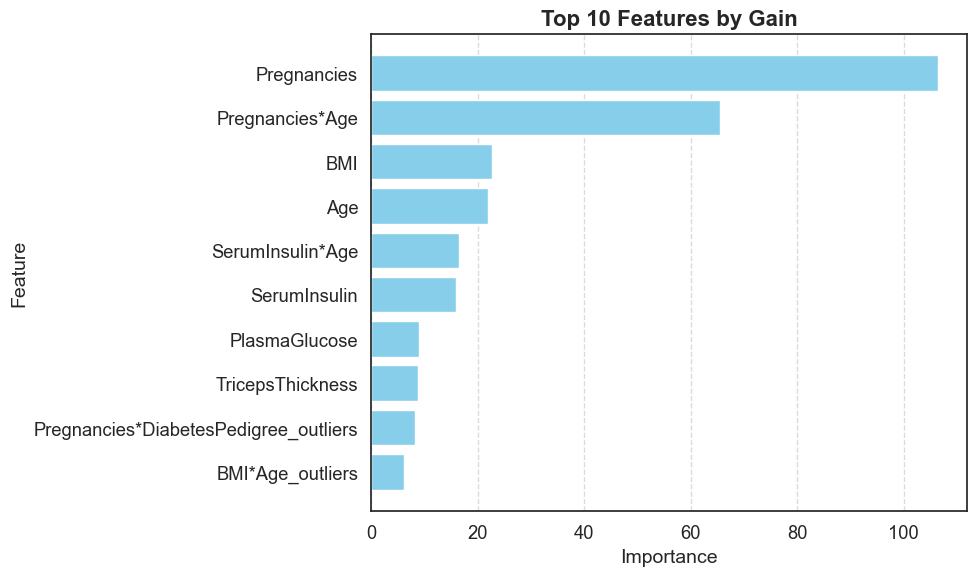

In [189]:
X = df[df.columns.drop("Diabetic")]
y = df["Diabetic"]

# Train the XGBoost model on the worst-performing fold's training data
xgboost = XGBClassifier(eval_metric="logloss", random_state=42).fit(X,y)
plot_feature_importance(xgboost, importance_type='gain', max_features=10)

Well, we can see that this was a pretty effective idea, remember that the **Pregnancies** variable was outstanding with other in term of importance, but now we have add at least one variable able to compete with it better than what we used to have. And notice that the importance of the **Pregnancies** variable went from around 50 to now other a 100 points we guess it is due to the number 2 most important variable which is the interaction between **Pregnancies and Age**.

Adding those new variables, have lead to go from **8 features in our dataset to now 102**, and that cost us pretty much nothing in term of computationnal cost.

But generaly, this may not be best pratice if we are working this a lot more important dataset size, but here, with our configuration and the goal being to out perform other models, we have taken that decision that finally paid quick well.

Without further do, let's have a deeper look at the distribution of the variable importance in the model.

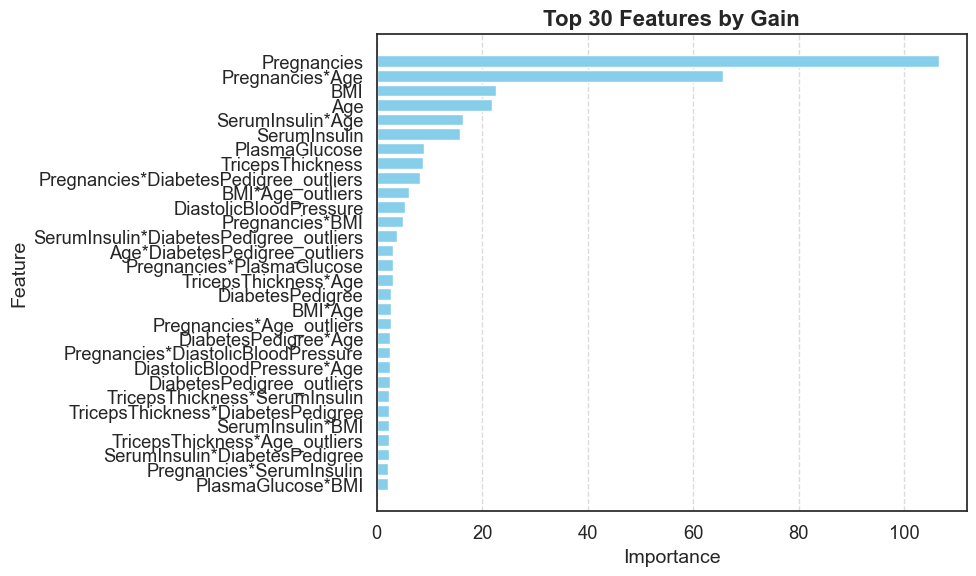

In [192]:

plot_feature_importance(xgboost, importance_type='gain', max_features=30)

This model have the particularity to have the **L1** and **L2** regulation (lasso and ridge) so the algorith already takes care of deleting and keeping features or reduce their impact on the algorithm.

By default, we have the **100% Rigde** and **0% lasso** now let's changes that.

Let's add **100% Lasso (features deletion)** to the **100% Ridge** and check which ones the model have keeped.

Let's start by checking the shape of the **average gain** features distribution graphic shape first.

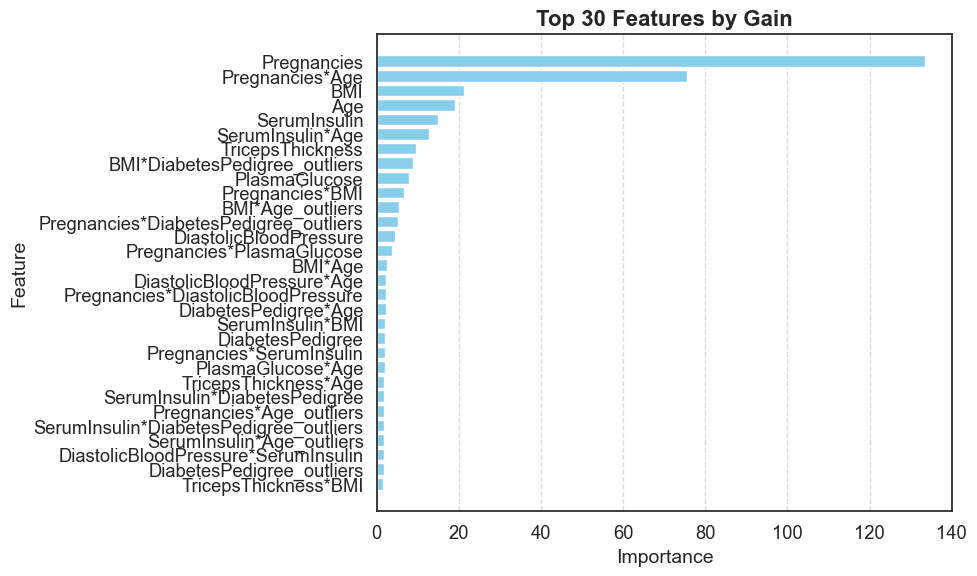

In [195]:
xgboost = XGBClassifier(eval_metric="logloss", alpha=1.0, random_state=42).fit(X,y)
plot_feature_importance(xgboost, importance_type='gain', max_features=30)

We can notice some changes, but like dive deeper add look how this impact the number of features in the dataframe.

In [197]:
importance = xgboost.get_booster().get_score(importance_type='gain')  # or use 'gain'

# Total number of features kept
kept_features = len([score for score in importance.values() if score > 0])
print(f"Number of features kept: {kept_features}")


Number of features kept: 52


We have been able to reduc the number of feature from **102** to **52** which is almost divided by **2** the feature required.

Well, as we can see, we have a lot of variable (remaining) that are not that relevant so we may just drop them a way even if the model have decided to keep them.

One technique used in for example **PCA** is the **elbow effect**, which mean, that when we have an important gape between a cluster of variable, that is where we can decide do drop away the least performing ones.

Add Here, doing it, will mean do keep only the first to variables.

I personnaly want to try to just keep the top **6** more important features in terme of average gain on the model performance.

Number of features kept after selection: 52
Top 6 features: ['Pregnancies', 'Pregnancies*Age', 'BMI', 'Age', 'SerumInsulin*Age', 'SerumInsulin']


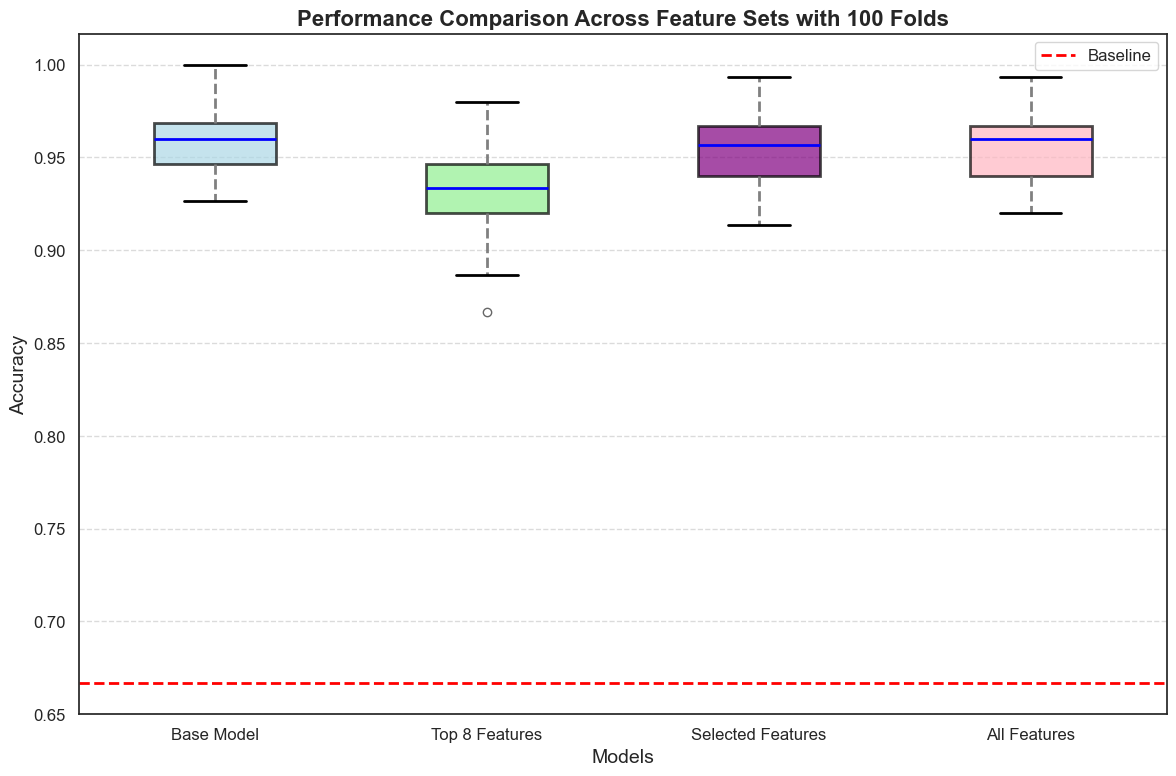

In [201]:

def kfold_evaluation_single_model(model, X, y, n_splits=5, random_state=42):
    """
    Evaluate a single model using Stratified K-Fold cross-validation.
    
    Parameters:
    - model: estimator
        The model to be evaluated.
    - X: pd.DataFrame
        Feature matrix.
    - y: pd.Series or np.array
        Target variable.
    - n_splits: int, optional (default=5)
        Number of folds in Stratified K-Fold.
    - random_state: int, optional (default=42)
        Random state for reproducibility.
        
    Returns:
    - results: list
        List of accuracy scores for each fold.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    results = []
    
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results.append(accuracy)
    
    return results



# Train the initial XGBoost model to compute feature importances
xgboost = XGBClassifier(eval_metric="logloss", random_state=42)
xgboost.fit(X, y)

# Feature importance based on gain
importance = xgboost.get_booster().get_score(importance_type='gain')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
selected_features = [f for f, score in sorted_importance if score > 0]  # Retained features
top_6_features = [f for f, _ in sorted_importance[:6]]  # Top 8 features

# Check retained features
print(f"Number of features kept after selection: {len(selected_features)}")
print(f"Top 6 features: {top_6_features}")

# Feature sets
X_all = X  # All features
X_selected = X[selected_features]  # Selected features (based on gain)
X_top6 = X[top_6_features]  # Top 8 features
X_base = X[X.columns[:8]] # Basic features

# Perform K-Fold evaluation for each feature set
results_all = kfold_evaluation_single_model(XGBClassifier(eval_metric="logloss", random_state=42), X_all, y, n_splits=100)
results_selected = kfold_evaluation_single_model(XGBClassifier(eval_metric="logloss", random_state=42), X_selected, y, n_splits=100)
results_top6 = kfold_evaluation_single_model(XGBClassifier(eval_metric="logloss", random_state=42), X_top6, y, n_splits=100)
results_base_model = kfold_evaluation_single_model(XGBClassifier(eval_metric="logloss", random_state=42), X_base, y, n_splits=100)
# Combine results for boxplot comparison
combined_results = {
    "Base Model": results_base_model,
    "Top 8 Features": results_top6,
    "Selected Features": results_selected,
    "All Features": results_all,
}

# Baseline accuracy
baseline_accuracy = y.value_counts(normalize=True).max()

# Plot results
plot_kfold_results(combined_results, baseline_accuracy, title="Performance Comparison Across Feature Sets with 100 Folds")

Alright, we can see thta we have not add a lot of value to the performances to model.

If we compare the base model and the model with all the features, we see pretty much no differences and remember that we have added almost a **100 features**. So we will just keep the dataset as it was in the beginning with only 8 features

In [203]:
df = df[df.columns[:9]]

del X,y

#check the work 
#df.head(3)

Let's continue with the optimization of our model performance by tuning the hyperparameters.

As any model, we can of course optimize the feature it takes and also the hyperparameters of the model.

Tuning parameters can be high in term of computationnal costs, unless if we use the optuna library that is an implemented version of the **TPE** algorithm.

Let's talk about the algorithm and why it better that brute force optimization methods.

The **Tree-structured Parzen Estimator (TPE)** is a Bayesian optimization algorithm used to efficiently find the best hyperparameters. It models the objective function by dividing past trials into two groups:

1. **Good Trials**: Trials with the best performance (e.g., highest accuracy or lowest loss).
2. **Bad Trials**: All other trials.

It then builds probability distributions for each group and selects hyperparameters that maximize the ratio \( g(x) / l(x) \), where:
- \( g(x) \): Probability of the hyperparameter belonging to the "good" trials.
- \( l(x) \): Probability of the hyperparameter belonging to the "bad" trials.

This approach balances exploration (trying new areas) and exploitation (focusing on promising areas), making it highly efficient for optimizing hyperparameters in machine learning models.

The **Tree-structured Parzen Estimator (TPE)** is particularly interesting because it dynamically learns and adapts the search space based on the results of previous trials, making it much more efficient than traditional methods like **grid or random search**. Instead of wasting resources exploring less promising areas of the search space, TPE focuses on regions with higher potential by prioritizing hyperparameters that are more likely to improve the objective.

This adaptability makes TPE highly effective for complex and high-dimensional problems where brute-force or static methods would require excessive computation. Its balance between exploration (discovering new possibilities) and exploitation (refining promising areas) ensures that resources are used optimally. TPE's ability to handle diverse types of hyperparameters (categorical, continuous, and discrete) further adds to its versatility and appeal, making it a go-to choice for hyperparameter optimization.

In [205]:
import xgboost as xgb
import optuna
from optuna.samplers import TPESampler


def objective_xgboost(trial, X, y, n_splits=20, random_state=42):
    """
    Objective function for Bayesian Optimization of XGBoost using Optuna,
    including loss function and scale_pos_weight optimization.
    """
    # Define hyperparameter space
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1, 10),  # Optimize class balancing
        "objective": trial.suggest_categorical(
            "objective", ["binary:logistic", "binary:logitraw", "binary:hinge"]
        ),  # Optimize loss function
        "eval_metric": "logloss",
        "tree_method": "hist",
        "verbosity": 0,
        "seed": random_state
    }

    # Perform Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    accuracies = []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Convert to DMatrix format
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)

        # Train the model
        bst = xgb.train(
            param,
            dtrain,
            num_boost_round=param["n_estimators"],
            evals=[(dtest, "validation")],
            early_stopping_rounds=50,
            verbose_eval=False
        )

        # Predict and evaluate
        y_pred = (bst.predict(dtest) > 0.5).astype(int)
        accuracies.append(accuracy_score(y_test, y_pred))

    return np.mean(accuracies)


def optimize_xgboost(X, y, n_trials=100, n_splits=20, random_state=42):
    """
    Optimize XGBoost using Bayesian Optimization with Optuna,
    including loss function and scale_pos_weight optimization.
    """
    study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=random_state))
    study.optimize(
        lambda trial: objective_xgboost(trial, X, y, n_splits, random_state),
        n_trials=n_trials,
    )

    print("Best parameters:", study.best_params)
    print("Best cross-validated accuracy:", study.best_value)

    # Refit the best model with XGBClassifier
    best_params = study.best_params
    final_model = XGBClassifier(
        n_estimators=best_params["n_estimators"],
        learning_rate=best_params["learning_rate"],
        max_depth=best_params["max_depth"],
        subsample=best_params["subsample"],
        colsample_bytree=best_params["colsample_bytree"],
        gamma=best_params["gamma"],
        min_child_weight=best_params["min_child_weight"],
        scale_pos_weight=best_params["scale_pos_weight"],  # Best scale_pos_weight
        objective=best_params["objective"],  # Best loss function
        tree_method="hist",
        use_label_encoder=False,
        random_state=random_state
    )
    final_model.fit(X, y)

    return final_model, study

X = df[df.columns.drop("Diabetic")]
y = df["Diabetic"]

# Results from K-Fold evaluations

results_basic = kfold_evaluation_single_model(XGBClassifier(eval_metric="logloss", random_state=42), X, y, n_splits=100)
optimized_model, study = optimize_xgboost(X, y, n_trials=100, n_splits=10)
results_optimized = kfold_evaluation_single_model(loaded_model, X, y, n_splits=100)results_optimized = kfold_evaluation_single_model(loaded_model, X, y, n_splits=100)

# Combine results for boxplot comparison
combined_results = {
    "Basic Model": results_basic,
    "Optimized Model": results_optimized,
}

# Baseline Accuracy
baseline_accuracy = np.mean(results_basic)

# Plot Results
plot_kfold_results(combined_results, baseline_accuracy, title="Performance with 100-Folds: Basic vs Optimized XGBoost")

SyntaxError: invalid syntax (430775954.py, line 100)

In [ ]:
!pip install optuna

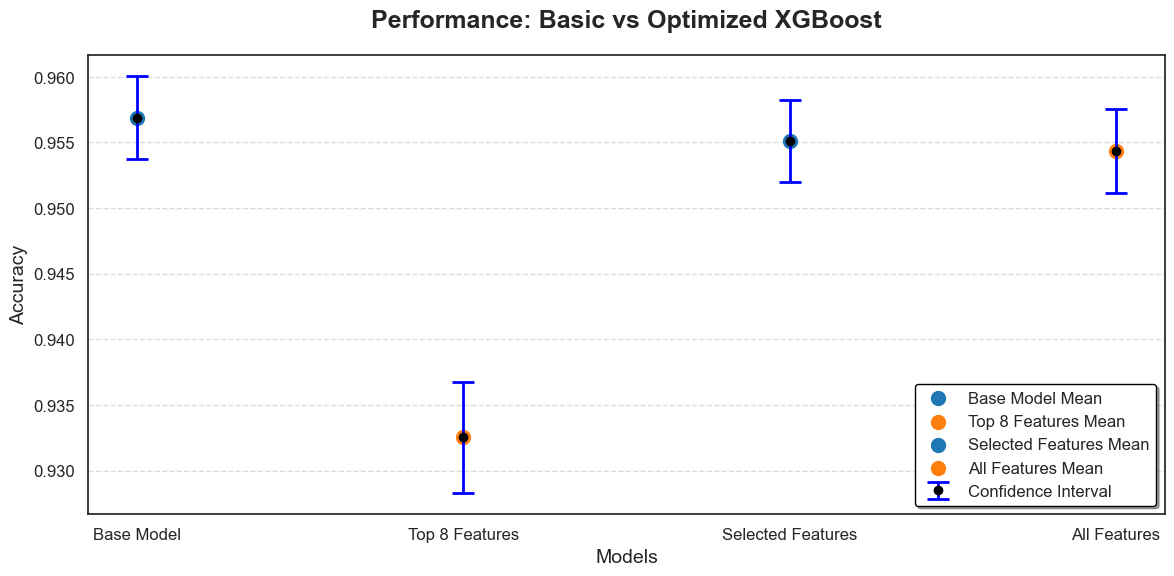

In [209]:
# Bootstrap Confidence Interval Function
def bootstrap_confidence_interval(data, confidence=0.95, n_bootstrap=1000000, random_state=42):
    np.random.seed(random_state)
    bootstrapped_means = [
        np.mean(np.random.choice(data, size=len(data), replace=True))
        for _ in range(n_bootstrap)
    ]
    lower_bound = np.percentile(bootstrapped_means, (1 - confidence) / 2 * 100)
    upper_bound = np.percentile(bootstrapped_means, (1 + confidence) / 2 * 100)
    return lower_bound, upper_bound



def plot_performance_with_error_bars(results, confidence=0.95, title="Model Performance with Error Bars"):
    """
    Plot the performance of models with error bars representing confidence intervals.

    Parameters:
    - results: dict
        Dictionary containing accuracy results for each model.
    - confidence: float, optional (default=0.95)
        Confidence level for the intervals.
    - title: str, optional
        Title of the plot.
    """
    plt.figure(figsize=(12, 6))
    
    means = []
    ci_lowers = []
    ci_uppers = []
    labels = list(results.keys())
    x_positions = np.arange(len(labels))
    
    # Calculate mean and confidence intervals for each model
    for label, data in results.items():
        mean = np.mean(data)
        ci_lower, ci_upper = bootstrap_confidence_interval(data, confidence=confidence)
        means.append(mean)
        ci_lowers.append(mean - ci_lower)
        ci_uppers.append(ci_upper - mean)
    
    # Plot error bars
    plt.errorbar(
        x_positions, means, yerr=[ci_lowers, ci_uppers], fmt='o',
        color='black', ecolor='blue', elinewidth=2, capsize=8, capthick=2, label="Confidence Interval"
    )
    
    # Add scatter points with distinct colors
    scatter_colors = ['#1f77b4', '#ff7f0e']  # Define custom colors
    for i, mean in enumerate(means):
        plt.scatter(x_positions[i], mean, color=scatter_colors[i % len(scatter_colors)], s=100, label=f"{labels[i]} Mean" if i < len(labels) else None)
    
    # Format axes and labels
    plt.xticks(x_positions, labels, fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(title, fontsize=18, fontweight="bold", pad=20)
    plt.ylabel("Accuracy", fontsize=14)
    plt.xlabel("Models", fontsize=14)
    
    # Grid and legend for better aesthetics
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(fontsize=12, loc="lower right", frameon=True, shadow=True, edgecolor="black")
    
    # Tight layout for better spacing
    plt.tight_layout()
    plt.show()

# Example Usage with combined_results
plot_performance_with_error_bars(combined_results, confidence=0.95, title="Performance: Basic vs Optimized XGBoost")
